In [1]:
# https://en.m.wikipedia.org/wiki/List_of_majority-minority_United_States_congressional_districts
state = 'SD'    # 2-letter state code
level = 'tract' # county, tract, block

In [2]:
filepath = 'C:\\districting-data-2020\\'
filename = state + '_' + level + '.json'

# GerryChain has a built-in function for reading graphs of this type:
from gerrychain import Graph
G = Graph.from_json( filepath + filename )

for node in G.nodes:
    # See http://starr.tamu.edu/files/2013/01/Census-Codes.pdf
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001']
    
    # voting age population (VAP)
    G.nodes[node]['VAP'] = G.nodes[node]['P0030001']
    
    # American Indian and Alaska Native alone:
    G.nodes[node]['NVAP'] = G.nodes[node]['P0030005']
    
    # American Indian and Alaska Native (among two races)
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030012']
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030016']
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030020']
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030021']
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030022']
    
    # American Indian and Alaska Native (among three races)
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030027']
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030031']
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030032']
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030033']

    G.nodes[node]['NVAP'] += G.nodes[node]['P0030037']
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030038']
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030039']
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030043']
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030044']
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030045']
    
    # American Indian and Alaska Native (among four races)
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030048']
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030049']
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030050']
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030054']
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030055']
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030056']
    
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030058']
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030059']
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030060']
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030062']
    
    # American Indian and Alaska Native (among five races)
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030064']
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030065']
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030066']
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030068']
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030069']
    
    # American Indian and Alaska Native (among fix races)
    G.nodes[node]['NVAP'] += G.nodes[node]['P0030071']

In [3]:
# Let's impose a 10% population deviation (+/-5%)
deviation = 0.10
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes )

import math
from number_of_districts import state_senate_districts_2020
k = state_senate_districts_2020[state]

# triple district
size = 3
L = size * math.ceil( ( 1 - deviation / 2 ) * total_population / k )
U = size * math.floor( ( 1 + deviation / 2 ) * total_population / k )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 72201 and U = 79800 and k = 35


In [4]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

import networkx as nx
DG = nx.DiGraph(G)   # directed version of G

# create variables
# x[i] equals one when tract i is selected
x = m.addVars(G.nodes, vtype=GRB.BINARY)  

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-27


In [5]:
# get county graph too
filename = state + '_county.json'
GC = Graph.from_json( filepath + filename )

for node in GC.nodes:
    # See http://starr.tamu.edu/files/2013/01/Census-Codes.pdf
    GC.nodes[node]['TOTPOP'] = GC.nodes[node]['P0010001']

gtn = { GC.nodes[i]['GEOID20'] : i for i in GC.nodes }

In [6]:
# Avoid Hughes
avoid = set()
for c in GC.nodes:
    if GC.nodes[c]['NAME20'] in {'Hughes'}:
        avoid.add( GC.nodes[c]['GEOID20'] )
        
for i in G.nodes:
    if G.nodes[i]['GEOID20'][0:5] in avoid:
        x[i].UB = 0

In [7]:
# # split at most 2 counties
splits = 2
whole = m.addVars(GC.nodes, vtype=GRB.BINARY)
some = m.addVars(GC.nodes, vtype=GRB.BINARY)
split = m.addVars(GC.nodes, vtype=GRB.BINARY)

m.addConstr( gp.quicksum(split) <= splits )
m.addConstrs( split[c] == some[c] - whole[c] for c in GC.nodes )

for i in G.nodes:
    g = G.nodes[i]['GEOID20'][0:5]
    c = gtn[g]
    m.addConstr( whole[c] <= x[i] )
    m.addConstr( x[i] <= some[c] )

In [8]:
# y[u,v] equals one when arc (u,v) is cut because u but not v is selected
y = m.addVars(DG.edges, vtype=GRB.BINARY) 

# z is inverse Polsby-Popper score for district 
z = m.addVar()

# A = area of district 
A = m.addVar()

# P = perimeter of district 
P = m.addVar()

In [9]:
# objective is to minimize inverse Polsby-Popper score
m.setObjective( z, GRB.MINIMIZE )

In [10]:
# add SOCP constraints relating inverse Polsby-Popper score z to area and perimeter
m.addConstr( P * P <= 4 * math.pi * A * z )

# add constraint on area A 
m.addConstr( A == gp.quicksum( G.nodes[i]['area'] * x[i] for i in G.nodes ) )

# add constraint on perimeter P
m.addConstr( P == gp.quicksum( DG.edges[u,v]['shared_perim'] * y[u,v] for u,v in DG.edges )
             + gp.quicksum( G.nodes[i]['boundary_perim'] * x[i] for i in G.nodes if G.nodes[i]['boundary_node'] ) )
    
m.update()

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


In [11]:
# add constraints saying that district has population at least L and at most U
m.addConstr( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i] for i in G.nodes) >= L )
m.addConstr( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i] for i in G.nodes) <= U )

# add constraints saying that arc (u,v) is cut if u but not v is selected
m.addConstrs( x[u] - x[v] <= y[u,v] for u,v in DG.edges )

m.update()

In [12]:
# To solve the MIP faster, fix a district root in Oglala Lakota
for i in G.nodes:
    if G.nodes[i]['GEOID20'][0:5] == '46102':
        ol = i
        break
    
x[ol].LB = 1

# Add flow variables: f[u,v] = amount of flow sent across arc uv 
#  Flows are sent across arcs of the directed version of G which we call DG

f = m.addVars( DG.edges )

In [13]:
# contiguity constraints
M = G.number_of_nodes()

# if selected but not a root, consume one unit of flow
m.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in G.neighbors(i) ) == x[i] for i in G.nodes if i != ol )

# flow can only enter selected nodes
m.addConstrs( gp.quicksum( f[j,i] for j in G.neighbors(i) ) <= M * x[i] for i in G.nodes if i != ol )

m.update()

In [14]:
# native_vap >= 0.5 * total_vap
nvap = m.addVar()
vap = m.addVar()

m.addConstr( nvap == gp.quicksum( G.nodes[i]['NVAP'] * x[i] for i in G.nodes ) )
m.addConstr( vap == gp.quicksum( G.nodes[i]['VAP'] * x[i] for i in G.nodes ) )

m.addConstr( nvap >= 0.5 * vap )

<gurobi.Constr *Awaiting Model Update*>

In [15]:
# solve IP model
m.Params.TimeLimit = 3600
m.optimize()

Set parameter TimeLimit to value 3600
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2280 rows, 2925 columns and 11645 nonzeros
Model fingerprint: 0xe27c7939
Model has 1 quadratic constraint
Variable types: 1245 continuous, 1680 integer (1680 binary)
Coefficient statistics:
  Matrix range     [1e-04, 9e+03]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 8e+04]
Presolve removed 139 rows and 79 columns
Presolve time: 0.15s
Presolved: 2141 rows, 2846 columns, 11166 nonzeros
Presolved model has 1 quadratic constraint(s)
Variable types: 1184 continuous, 1662 integer (1654 binary)

Root relaxation: objective 1.300644e-02, 1167 iterations, 0.12 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It

In [16]:
print("The inverse PP score is",m.objval)
print("The PP score is",1.0/m.objval)

# retrieve the districts and their populations
district = [i for i in G.nodes if x[i].x > 0.5] 
district_population = sum(G.nodes[i]["TOTPOP"] for i in district )

The inverse PP score is 2.5042222653938655
The PP score is 0.399325576574857


In [17]:
print("native_vap =", round(nvap.x) )
print("total_vap =", round(vap.x) )
print("percentage =", round( 100 * nvap.x / vap.x ),"%" )

native_vap = 24678
total_vap = 49342
percentage = 50 %


In [18]:
# Let's draw it on a map
import geopandas as gpd

In [19]:
filename = state + '_' + level + '.shp'
df = gpd.read_file( filepath + filename )

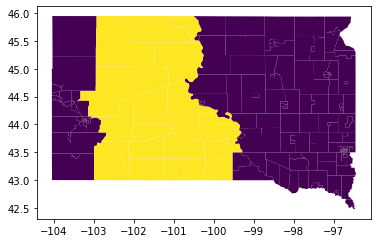

In [20]:
assignment = [ -1 for i in G.nodes ]
labeling = { i : 1 if x[i].x > 0.5 else 0 for i in G.nodes }

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()

In [21]:
county_geoids = { G.nodes[i]['GEOID20'][0:5] for i in G.nodes }
county_pop = { g : 0 for g in county_geoids }

In [22]:
for i in labeling.keys():
    if labeling[i]==1:
        g = G.nodes[i]['GEOID20'][0:5]
        p = G.nodes[i]['TOTPOP']
        county_pop[g] += p

In [23]:
count = 0
print("geoid pop total_pop county")
for g in county_pop.keys():
    if county_pop[g]>0:
        i = gtn[g]
        print(g,county_pop[g],GC.nodes[i]['TOTPOP'],GC.nodes[i]['NAME20'],100*county_pop[g]/GC.nodes[i]['TOTPOP'])
        count += 1
print(count)

geoid pop total_pop county
46121 9319 9319 Todd 100.0
46102 13672 13672 Oglala Lakota 100.0
46095 1918 1918 Mellette 100.0
46137 2413 2413 Ziebach 100.0
46103 3957 109222 Pennington 3.622896486055923
46093 7772 29852 Meade 26.03510652552593
46031 3902 3902 Corson 100.0
46041 5239 5239 Dewey 100.0
46117 2980 2980 Stanley 100.0
46123 5624 5624 Tripp 100.0
46055 1872 1872 Haakon 100.0
46085 3718 3718 Lyman 100.0
46075 917 917 Jones 100.0
46071 2806 2806 Jackson 100.0
46007 3381 3381 Bennett 100.0
46105 2835 2835 Perkins 100.0
16


In [24]:
nx.is_connected(G.subgraph(district))

True